<a href="https://colab.research.google.com/github/yusufemrekatkat/E-Commerce-Analytics-Basic_Projects/blob/main/Sentinel_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1: Generate Synthetic "Normal" and "Fraud" Data


**Regular** customers make **reasonable** purchases, on the other hand, the *cheaters* make *very little* (scam attempts) or *very large* (huge scam) purchases.


And this is a ***Unsupervised Learning*** that we are giving a job to the model to find the hidden structures in the raw data.

Data Summary:
            Amount  Time_Diff_Sec
count  1000.000000    1000.000000
mean    135.277386    3548.125641
std     222.738323     815.772143
min      35.174653       1.355136
25%      87.763290    3209.176697
50%     101.194486    3612.774968
75%     114.043408    4024.881068
max    1984.013163    5515.864541


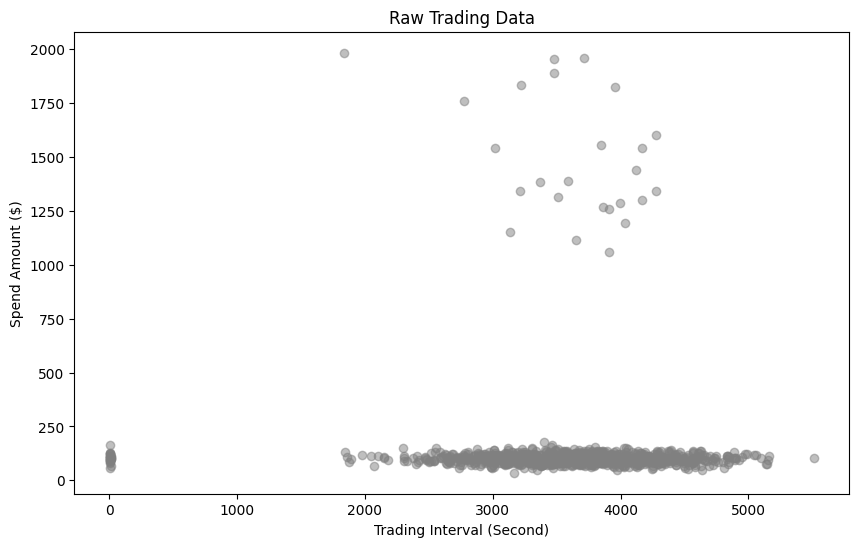

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# 1. VERİ SİMÜLASYONU
np.random.seed(42)

def generate_transaction_data(n_samples=1000, contamination=0.05):
    # --- Normal İşlemler (%95) ---
    n_normal = int(n_samples * (1 - contamination))

    # Normal harcamalar: Ort 100$, Std 50$ (Gauss Dağılımı)
    normal_amounts = np.random.normal(100, 20, n_normal)
    # İşlem sıklığı (saniye cinsinden aralık): Ort 3600sn (1 saat)
    normal_time_diffs = np.random.normal(3600, 600, n_normal)

    # --- Anormal (Fraud) İşlemler (%5) ---
    n_outliers = int(n_samples * contamination)

    # Fraud 1: Çok yüksek tutarlar (Vurgun)
    fraud_amounts_high = np.random.uniform(1000, 2000, n_outliers // 2)
    # Fraud 2: Çok sık işlemler (Bot saldırısı - 10 saniyede bir işlem)
    fraud_time_diffs_low = np.random.uniform(1, 10, n_outliers // 2)

    # Fraud verilerini birleştir (Tutarı normal ama süresi garip veya tam tersi)
    # Basitlik için sadece yüksek tutarları ve rastgele süreleri alalım
    outlier_amounts = np.concatenate([fraud_amounts_high, np.random.normal(100, 20, n_outliers // 2)])
    outlier_time_diffs = np.concatenate([np.random.normal(3600, 600, n_outliers // 2), fraud_time_diffs_low])

    # Verileri Birleştir
    amounts = np.concatenate([normal_amounts, outlier_amounts])
    time_diffs = np.concatenate([normal_time_diffs, outlier_time_diffs])

    data = pd.DataFrame({'Amount': amounts, 'Time_Diff_Sec': time_diffs})

    return data

df = generate_transaction_data()
print("Data Summary:")
print(df.describe())

# Veriyi Görselleştir (Henüz kim suçlu bilmiyoruz)
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_Diff_Sec'], df['Amount'], c='gray', alpha=0.5)
plt.title('Raw Trading Data')
plt.xlabel('Trading Interval (Second)')
plt.ylabel('Spend Amount ($)')
plt.show()

# 2: Finding Criminal with ISolation Forest


We are training the model: Data is dirty with %5, find them. (contamination=0.05)

In [5]:
# 2. MODEL EĞİTİMİ (Unsupervised)

# Isolation Forest Modeli
# contamination: Tahmin ettiğimiz dolandırıcılık oranı
model = IsolationForest(contamination=0.05, random_state=42)

# Modeli eğit ve tahmin et
# Sonuçlar: 1 (Normal), -1 (Anomali)
df['anomaly_score'] = model.fit_predict(df[['Amount', 'Time_Diff_Sec']])

# Sonuçları daha anlaşılır yapalım: "Normal" veya "Fraud"
df['status'] = df['anomaly_score'].apply(lambda x: 'Normal' if x == 1 else 'Fraud')

print(df['status'].value_counts())

status
Normal    950
Fraud      50
Name: count, dtype: int64


# 3: Visualize Results

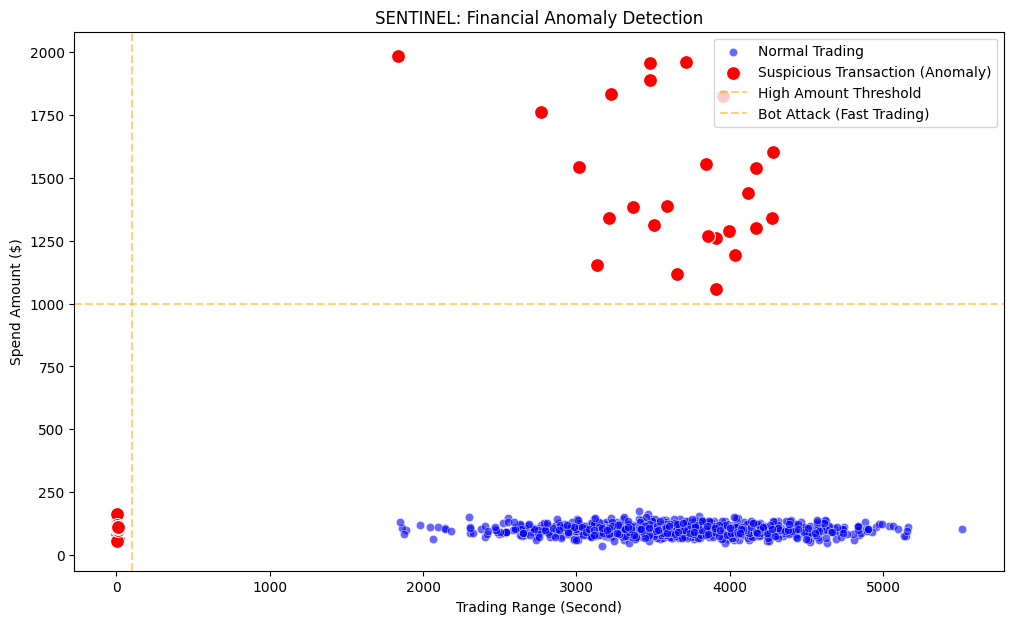

In [8]:
# 3. Visualization

plt.figure(figsize=(12, 7))

# Normaller (Mavi)
sns.scatterplot(x='Time_Diff_Sec', y='Amount', data=df[df['status']=='Normal'],
                color='blue', label='Normal Trading', alpha=0.6)

# Fraudlar (Kırmızı)
sns.scatterplot(x='Time_Diff_Sec', y='Amount', data=df[df['status']=='Fraud'],
                color='red', label='Suspicious Transaction (Anomaly)', s=100) # s=100 ile noktaları büyüttük

plt.axhline(y=1000, color='orange', linestyle='--', alpha=0.5, label='High Amount Threshold')
plt.axvline(x=100, color='orange', linestyle='--', alpha=0.5, label='Bot Attack (Fast Trading)')

plt.title('SENTINEL: Financial Anomaly Detection')
plt.xlabel('Trading Range (Second)')
plt.ylabel('Spend Amount ($)')
plt.legend()
plt.show()